-----Reading XML

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
tree = ET.parse(r'C:\Users\cid2r\Downloads\db\discogs_20220201_masters.xml')
#tree = ET.parse('rel.xml')
root = tree.getroot()

----Data Scraping

In [ ]:
pip install python3-discogs-client

In [ ]:
import discogs_client

d = discogs_client.Client('ExampleApplication/0.1', user_token = 'WkcTWMWNFmwUFYHrtQIreHRnLmyFZTNnkflNHsgc')


In [ ]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"


In [ ]:
#0310추가
import requests
import shutil
#0312추가
import requests
from bs4 import BeautifulSoup
import json



for release in root.iter('master'):
    id = release.attrib.get('id')
    
    if int(id) > 70630:


        master_scarp = 'https://www.discogs.com/master/' + str(id)
        soup = BeautifulSoup(requests.get(master_scarp).text)
        rslt = soup.find('script', attrs={'id':'master_schema'})
        if rslt == None:
            rating = 0
        else:
            json_file = json.loads(rslt.get_text())
            rating = json_file['@graph'][0]['aggregateRating']['ratingCount']
            
        standard = 1000 if 'Electronic' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            else 500 if ('Rock' in literal_eval(str(json_file['@graph'][0]['genre']))) else 150
    
        if rating >= standard:
            
            print(id)
    
            gens=[]
            for gen in release.iter('genre'):
               gens.append(gen.text)
    
            imglnk = d.master(id).images
            if(imglnk != None):
                if('uri150' in imglnk[0]):
                    uri = imglnk[0]['uri150']
    
        
            if len(gens) == 1:
                if gens[0] == 'Funk / Soul':
                    gens[0] = 'Funk&Soul'
                makedirs(win_dir+gens[0])
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, ('Funk&Soul' if gens[0] == 'Funk / Soul' else gens[0]), img_name)
                #0310add
                makedirs(os.path.join(win_dir, gens[0]))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'}, timeout=1)
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
            else:
                multi_dir = ''
                separator = '+'
                for idx, val in enumerate(gens):
                    multi_dir += ('Funk&Soul' if val == 'Funk / Soul' else val) + ('' if idx == len(gens) -1 else separator)
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, 'multi', multi_dir, img_name)
            
                makedirs(os.path.join(win_dir, 'multi',multi_dir))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'}, timeout=1)
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
            
            

    
        if(int(id) >= 74999):
            break

print("done! done!")



-----현재 안쓰는 코드

In [ ]:
'''
import os

#win
#db_list = os.listdir(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\data")

#mac
db_list = os.listdir(r"/Users/cooky/Documents/GitHub/0220dbtest/data")
'''

In [ ]:
'''
import pandas as pd


alldata = []

for file in db_list:
    df = pd.read_csv(file)
    alldata.append(df)

df_0_2_100k = pd.concat(alldata, axis=0, ignore_index=True)
df_0_2_100k.to_csv("/Users/cooky/Documents/GitHub/0220dbtest/data/output", index=False)

'''


In [ ]:
df_0_2_100k = pd.read_csv("data_20k_2_25k.csv")

df_test = df_0_2_100k.copy()
df_test.drop(columns='Unnamed: 0')

In [ ]:
from ast import literal_eval


for idx,row in df_test.iterrows():
    gen_str = row['genre']
    gens = literal_eval(gen_str)
    #print(idx)
    for gen in gens:
        if gen in df_test.columns:
            df_test.at[idx, gen] = 1
        else:
            df_test[gen] = 0
            df_test.at[idx, gen] = 1

            

            

In [ ]:
pd.crosstab(df_test.Jazz, df_test.Electronic)

In [ ]:
DISCOGS_KEY = 'OKxXReJmUJvMJRRsaOqr'
DISCOGS_SECRET = 'RormADbxpiujDCXDiBDwFGUFxKrVjkTK'

----실험실

In [ ]:
#win
#pip install fastai

#mac
conda install -c fastai fastai

In [1]:
import fastai

print(fastai.__version__)

2.5.3


In [2]:

macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"

BATCH_SIZE = 64

In [3]:
from fastai.vision.all import *

data = ImageDataLoaders.from_folder(path=macos_dir, valid_pct=0.2, seed=42, item_tfms=RandomResizedCrop(128, min_scale=0.35))

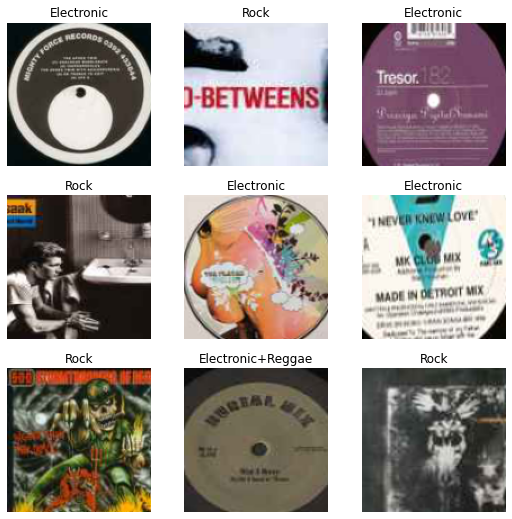

In [6]:
data.show_batch()

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

SuggestedLRs(valley=0.001737800776027143)

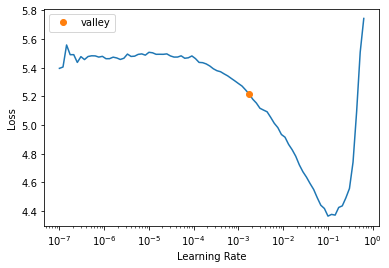

In [8]:
learn.lr_find()
#learn.recorder.plot()

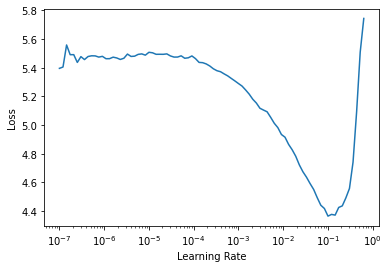

In [10]:
learn.recorder.plot_lr_find()

In [11]:
lr = 1e-3
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 